In [1]:
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pylab as plt
import geohash

# Read shop data

In [2]:
df = pd.read_csv('./data/shopdata.csv', sep = '\t')

In [3]:
df.shape

(11192, 5)

In order to ensure data security, the coordinate precision given here is only 3 digits after the decimal point, and the actual coordinate precision is 6 digits after the decimal point.

In [4]:
df.head()

,shopid,lon,lat,product_tags,label
0,214067,120.122,29.348,"女裤,女士拉绒保暖裤,袜,打底裤",130
1,501135,120.115,29.342,"棉织带,榨汁机,手动榨汁器,气泵,咖啡,太空杯,橡皮泥,亚克力飞机,卧式千斤顶,混纺船袜,钥...",17
2,501762,120.121,29.346,袜,130
3,501763,120.121,29.346,"男袜,男中筒袜,袜",130
4,501765,120.121,29.346,"抹胸,吊带背心,裤袜,连身衣,男士塑身连体衣",130


# calculate geohash code

In [5]:
df['geohash_5'] = df.apply(lambda x: geohash.encode(x['lon'], x['lat'], precision=5), axis=1)
df['geohash_6'] = df.apply(lambda x: geohash.encode(x['lon'], x['lat'], precision=6), axis=1)
df['geohash_7'] = df.apply(lambda x: geohash.encode(x['lon'], x['lat'], precision=7), axis=1)
df['geohash_8'] = df.apply(lambda x: geohash.encode(x['lon'], x['lat'], precision=8), axis=1)
df['geohash_9'] = df.apply(lambda x: geohash.encode(x['lon'], x['lat'], precision=9), axis=1)

In [6]:
df.head()

,shopid,lon,lat,product_tags,label,geohash_5,geohash_6,geohash_7,geohash_8,geohash_9
0,214067,120.122,29.348,"女裤,女士拉绒保暖裤,袜,打底裤",130,uxuzg,uxuzgz,uxuzgzf,uxuzgzfx,uxuzgzfxc
1,501135,120.115,29.342,"棉织带,榨汁机,手动榨汁器,气泵,咖啡,太空杯,橡皮泥,亚克力飞机,卧式千斤顶,混纺船袜,钥...",17,uxuzg,uxuzgx,uxuzgxy,uxuzgxyp,uxuzgxypy
2,501762,120.121,29.346,袜,130,uxuzg,uxuzgz,uxuzgzc,uxuzgzcp,uxuzgzcpg
3,501763,120.121,29.346,"男袜,男中筒袜,袜",130,uxuzg,uxuzgz,uxuzgzc,uxuzgzcp,uxuzgzcpg
4,501765,120.121,29.346,"抹胸,吊带背心,裤袜,连身衣,男士塑身连体衣",130,uxuzg,uxuzgz,uxuzgzc,uxuzgzcp,uxuzgzcpg


In [7]:
df.to_csv('./data/shopdata_geohash.csv', sep = '\t', index=False)

# Data Analysis

## label_counts

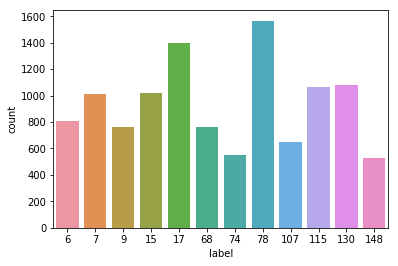

In [8]:
sns.countplot(df.label)

## size of product list context

In [9]:
def data_count(df):
    corpus = []
    dict = {}
    for index,row in df.iterrows():
        shopid = str(row.shopid)
        n = len(row.product_tags.split(','))
        dict[n] = dict.get(n, 0) + 1
    return dict

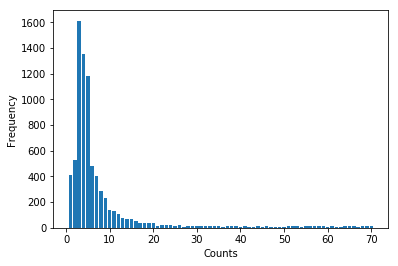

In [10]:
dict = data_count(df)
lists = sorted(dict.items())
x, y = zip(*lists[:70])
plt.bar(x, y)
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.show()

In [11]:
df['tag_len'] = pd.Series([len(i) for i in df.product_tags.str.split(',')])

In [12]:
df = df[df.tag_len <= 50]

## Number of codes of different length


Due to the use of low-precision coordinates, the accuracy of geohash is not enough

Text(0.5,0,'Counts')

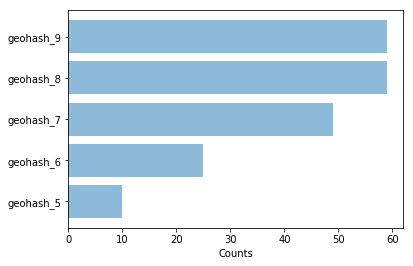

In [13]:
objects = ('geohash_5', 'geohash_6', 'geohash_7', 'geohash_8', 'geohash_9')
y_pos = np.arange(len(objects))
performance = [len(df.groupby(by=[col]).size()) for col in ['geohash_' + str(i) for i in range(5,10)]] 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Counts')

# Data Augmentation

In [14]:
frames = [df.copy() for i in range(20)]
df_expand = pd.concat(frames)
df_expand.shape

(153300, 11)

In [15]:
n = 0
for index, row in df_expand.iterrows():
    n += 1
    if row.tag_len > 30:
        sample_list = row.product_tags.split(',')
        df_expand.loc[index,'product_tags'] = ','.join(random.sample(sample_list, 30))
        df_expand.loc[index,'tag_len'] = 30
    if n % 10000 == 0:
        print('\r %d' % n, end='')

 150000

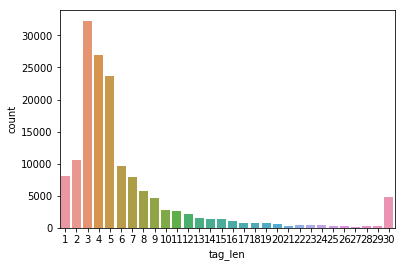

In [16]:
sns.countplot(df_expand.tag_len)

# Generator training corpus

In [17]:
import re
def get_corpus(df, type):
    corpus = []
    for index,row in df.iterrows():
        shopid = str(row['shopid'])
        for w in row.product_tags.split(','):
            if w == '':
                continue
            corpus.append([shopid, w])
        if type != 'geohash_0':
            corpus.append([shopid, row[type]])
    df_corpus = pd.DataFrame(corpus, columns = ['target', 'context'])
    path_corpus = "./data/" + type + "/" + type + ".txt"
    print(df_corpus.shape)
    df_corpus.to_csv(path_corpus, sep = ' ', index = False, encoding = 'utf-8', header=None)
    return df_corpus

In [18]:
list = ['geohash_0']
list.extend(['geohash_'+str(i) for i in range(5,10)])
list

['geohash_0', 'geohash_5', 'geohash_6', 'geohash_7', 'geohash_8', 'geohash_9']

In [ ]:
for type in list:
    get_corpus(df_expand, type)